# [IAPR 2019:][iapr2019] Special project

**Group members:**
    1- first name and last name,
    2- first name and last name,
    3- first name and last name

**Due date:** 30.05.2019

[iapr2019]: https://github.com/LTS5/iapr-2019


## Description
Please find the description of this special project via [this link].

[this link]: https://github.com/LTS5/iapr-2019/blob/master/project/special_project_description.pdf

## Part 1: Finding varroas by segmentation
Add your implementation for ''**detect_by_segmentation**'' function. Please make sure the input and output follows the mentioned format.

In [29]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'project-data/images/test'
tar_path = os.path.join(data_base_path, data_folder)

In [30]:
import skimage.io
# Load images
data_path = os.path.join(data_base_path, data_folder)
# im_names = ['5a2af8e6a07d5643ecfab2c2_32.00px_10', '5a43d413a07d567e7d04bebf_32.00px_4',
#             '5a1b1b02a07d5643ecfab28a_32.00px_12', '5bebdb7aa07d5618ff4c401c_32.00px_0']
# im_names = ['5a43d413a07d567e7d04bebf_32.00px_4']
im_names = []
for r, d, f in os.walk(data_path):
    for file in f:
        if '.jpg' in file:
            im_names.append(file)

im_names = [im[:-4] for im in im_names]
#Let's remove '5a0de18fa07d56baef59b1f8_32.00px_19' since it's a uniform color image and
#that make our algorithm fail.
im_names.remove('5a0de18fa07d56baef59b1f8_32.00px_19')

filenames = [os.path.join(data_path, name) + '.jpg' for name in im_names]
ic = skimage.io.imread_collection(filenames)
print('Number of images: ', len(ic))

Number of images:  49


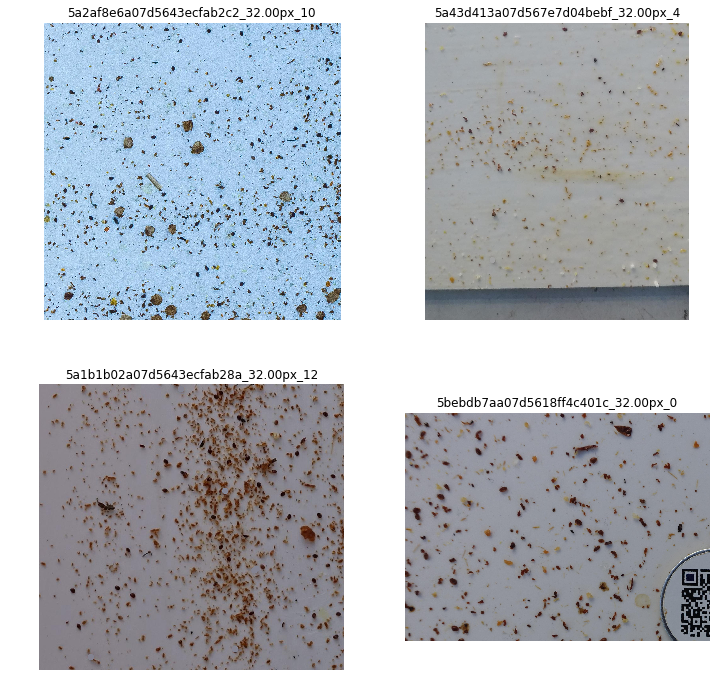

In [13]:
# import matplotlib.pyplot as plt
# # Plot images
# fig, axes = plt.subplots(2, 2, figsize=(12, 12))
# for ax, im, nm in zip(axes.ravel(), ic, im_names):
#     ax.imshow(im)
#     ax.axis('off')
#     ax.set_title(nm)
# plt.show()

### Parsing & Ploting

In [15]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [31]:
annotations_folder = "project-data/annotations/test"
annotations_path = os.path.join(data_base_path, annotations_folder)
annotations_xmls = [parse_file(os.path.join(annotations_path, name) + '.xml') for name in im_names]

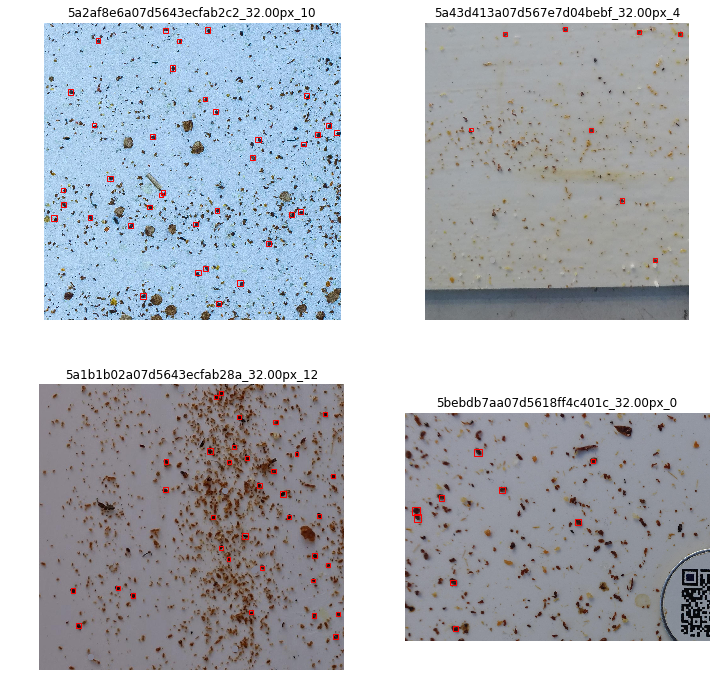

In [16]:
# import matplotlib.patches as patches
# # Plot images
# fig, axes = plt.subplots(2, 2, figsize=(12, 12))
# for ax, im, nm, annotations in zip(axes.ravel(), ic, im_names, annotations_xmls):
#     # Iterate over annotations
#     for anno in annotations:
#         rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
#                 linewidth=1,edgecolor='r',facecolor='none')
#         ax.add_patch(rect)
    
#     ax.imshow(im)
#     ax.axis('off')
#     ax.set_title(nm)
# plt.show()

### Segmentation

In [20]:
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops

def detect_by_segmentation(image):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''

    #Remove background
    value_img = rgb2gray(image)
    thresh = threshold_otsu(value_img)
    
    #Distinguish between two type of objects 
    thresh2 = threshold_otsu(value_img[value_img < thresh])
    binary = (value_img < thresh2)
    
    #Label image
    label_image = label(binary)
    proprieties = regionprops(label_image)
        
    #Parameters for the varroas size
    min_area = 400
    max_area = 750
    
    #Keep the label in the correct size range and with an approcimatively squared bbox
    large_label = [prop for prop in proprieties if ((prop.area > min_area) and (prop.area < max_area)) and 
                   (max(prop.bbox[3]-prop.bbox[1],prop.bbox[2]-prop.bbox[0])/min(prop.bbox[3]-prop.bbox[1],prop.bbox[2]-prop.bbox[0])<2)]
    
    output = []
    def mapping_fun(prop):
        ''' For each property received, it returns centroid position and width and height of the bbox'''
        y_i, x_i = prop.centroid
        min_row, min_col, max_row, max_col = prop.bbox
        return [x_i, y_i, max_row-min_row, max_col-min_col]
    
    for prop in large_label:
        output.append(mapping_fun(prop))
    
    return output

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [32]:
flabels = []
uniform_image = []
for index, im in enumerate(ic) :
    if (im.min() != im.max()):
        detections = detect_by_segmentation(im)
        flabels.append(detections)
    else: uniform_image.append(index)

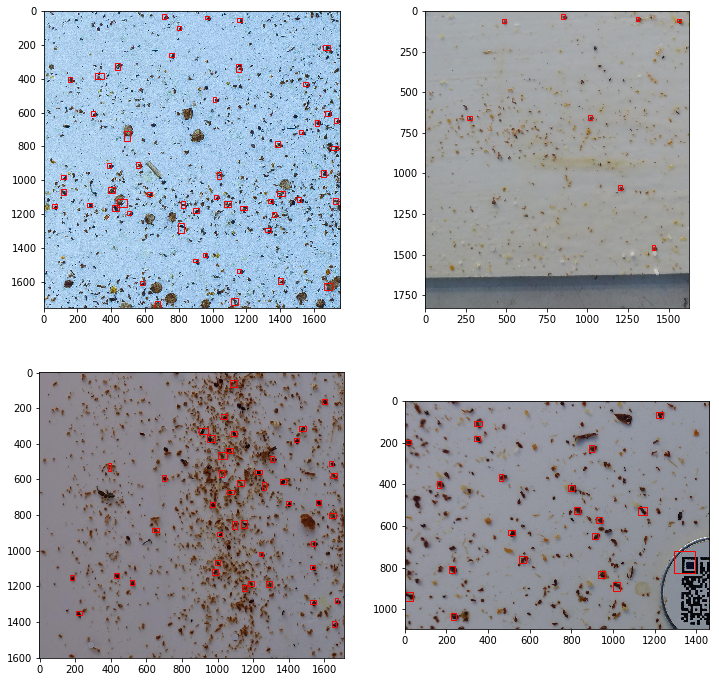

In [22]:
# ##Nice plotting axe
# fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# ##Finding the Varroas 
# flabels = []
# for ax, im in zip(axes.ravel(), ic) :
#     detections = detect_by_segmentation(im)
#     for detection in detections:
#          rect = patches.Rectangle((detection[0]-20, detection[1]-20), detection[2], detection[3],
#                  linewidth=1,edgecolor='r',facecolor='none')
#          ax.add_patch(rect)
#     flabels.append(detections)
#     ax.imshow(im) 

### Precision, Recall and F1-Score

In [33]:
from collections import namedtuple
def overlap(rect1, rect2):  
    '''Computes the overlapping area of two rectangle'''
    dx = min(rect1.xmax, rect2.xmax) - max(rect1.xmin, rect2.xmin)
    dy = min(rect1.ymax, rect2.ymax) - max(rect1.ymin, rect2.ymin)
    if (dx>=0) and (dy>=0):
        return dx*dy
    else: return 0

In [34]:
print(len(annotations_xmls))
print(len(flabels))

49
49


In [25]:
Rectangle = namedtuple('Rectangle', 'xmin, ymin, xmax, ymax')
IoU = []
zero_inter = []
for index, (imlabels,annotations) in enumerate(zip(flabels,annotations_xmls)):
    imIoU = []
    for imlabel in imlabels:
        inter_iou =[]
        
        for anno in annotations:
            grd_t = Rectangle(anno['bbox'][0], anno['bbox'][1], anno['bbox'][2]+anno['bbox'][0], anno['bbox'][3]+anno['bbox'][1])
            f_box = Rectangle(imlabel[0]-imlabel[2]/2, imlabel[1]-imlabel[3]/2, imlabel[0]+imlabel[2]/2, imlabel[1]+imlabel[3]/2)
            overlap_a = overlap(grd_t,f_box)
            if(overlap_a != 0): print(overlap_a); print("***********")
            grd_t_a = anno['bbox'][2]*anno['bbox'][3]
            f_box_a = (imlabel[2])*(imlabel[3])
            inter_iou.append(overlap_a/(grd_t_a+f_box_a-overlap_a))
            
        if inter_iou:
            imIoU.append(max(inter_iou))
        else : zero_inter.append(index)
    IoU.append(imIoU)

558.1885856079404
***********
528.6336515513118
***********
464.75
***********
616.0
***********
665.0002880776993
***********
462.21008403361407
***********
607.9767441860424
***********
711.7972463509116
***********
337.40588287646926
***********
538.4563106796127
***********
719.9753694581273
***********
399.9251874953564
***********
616.0
***********
302.33311928551313
***********
745.2740492170021
***********
508.7893968384021
***********
702.0
***********
540.7368421052629
***********
574.4798455211493
***********
583.601522491347
***********
651.8410776119301
***********
542.4431818181802
***********
693.0
***********
608.934306569342
***********
405.0400073708569
***********
576.0
***********
624.0
***********
561.7179226069246
***********
568.8153347732181
***********
528.0
***********
571.449240818697
***********
593.7500000000036
***********
215.3518024691363
***********
609.778705636746
***********
553.9268817204315
***********
403.69789674952176
***********
525.03691580842

In [26]:
def Precision_Recall_F1(IoU,ground_truth,number_image,T):
    '''Computes the required score for a given T value '''
    Precisions = []
    Recalls = []
    F1_scores =[]
    for imIoU,n in zip(IoU,range(number_image)):
        annotation = ground_truth[n]
        tp = [score for score in imIoU if(score >= T)]
        if (tp != 0) :
            #𝑝𝑟𝑒𝑐𝑖𝑠𝑖𝑜𝑛=𝑡𝑝/𝑡𝑝+𝑓𝑝 
            if(len(imIoU) != 0):
                Precision = len(tp)/(len(imIoU)) # tp+fp is every positive so every label that we selected
            else:
                Precision = 0
                
            #recall=𝑡𝑝/𝑡𝑝+𝑓𝑛
            if(len(annotations_xmls[n]) != 0):
                Recall = len(tp)/len(annotations_xmls[n]) # #fn = #grd truth - #tp so fn+tp = gt -tp + tp = gt
            else:
                Recall = 0
            #𝐹1=2⋅𝑝𝑟𝑒𝑐𝑖𝑠𝑖𝑜𝑛⋅𝑟𝑒𝑐𝑎𝑙𝑙/𝑝𝑟𝑒𝑐𝑖𝑠𝑖𝑜𝑛+𝑟𝑒𝑐𝑎𝑙𝑙
            if ((Precision + Recall) != 0):
                F1_score = (2 * Precision * Recall)/(Precision + Recall)
            else : 
                 F1_score = 0.0
            Precisions.append(Precision)
            Recalls.append(Recall)
            F1_scores.append(F1_score)
        else :
            Precisions.append(0.0)
            Recalls.append(0.0)
            F1_scores.append(0.0)
    return (Precisions,Recalls,F1_scores)

In [27]:
#Threshold = 0.5
Precisions_05,Recalls_05,F1_scores_05 =Precision_Recall_F1(IoU,annotations_xmls,49,0.3)


print("For a T value of 0.5:")
print("")
for precision,recall,score,im in zip(Precisions_05,Recalls_05,F1_scores_05,im_names):
    print("   Image %s: Precision: %g, Recall:  %r, F1_score: %s." % (im,precision,recall,score))
print("")

For a T value of 0.5:

   Image 5a2af8e6a07d5643ecfab2c2_32.00px_10: Precision: 0.509434, Recall:  0.75, F1_score: 0.6067415730337078.
   Image 5a43d413a07d567e7d04bebf_32.00px_4: Precision: 0.875, Recall:  0.875, F1_score: 0.875.
   Image 5a1b1b02a07d5643ecfab28a_32.00px_12: Precision: 0.568182, Recall:  0.7352941176470589, F1_score: 0.641025641025641.
   Image 5bebdb7aa07d5618ff4c401c_32.00px_0: Precision: 0.35, Recall:  0.7777777777777778, F1_score: 0.48275862068965514.



## Part 2: Implement your first detector

Write your function(s) for the second part. Feel free to change the name of the function and add your additional functions, but please make sure their input and output follows the mentioned format.

In [165]:
import os
import skimage
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.morphology import binary_opening, remove_small_objects
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray


data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'project-data/images/train'
data_path = os.path.join(data_base_path, data_folder)
im_names = ['59023fbd579e52581ddede9f_32.00px_32']
#im_names = ['5a2af8e6a07d5643ecfab2c2_32.00px_10']
#im_names = ['5bebdb7aa07d5618ff4c401c_32.00px_0']
# im_names = ['5a2af8e6a07d5643ecfab2c2_32.00px_10', '5a43d413a07d567e7d04bebf_32.00px_4',
#             '5a1b1b02a07d5643ecfab28a_32.00px_12', '5bebdb7aa07d5618ff4c401c_32.00px_0']
filenames = [os.path.join(data_path, name) + '.jpg' for name in im_names]
ic = skimage.io.imread_collection(filenames)
print('Number of images: ', len(ic))

Number of images:  1


In [166]:
#Plot standard
import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['figure.figsize'] = (8, 5)

mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 14

In [167]:
def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [168]:
annotations_folder = "project-data/annotations/train"
annotations_path = os.path.join(data_base_path, annotations_folder)
annotations_xmls = [parse_file(os.path.join(annotations_path, name) + '.xml') for name in im_names]

In [45]:
def plot_img_plus_segmentation(ic, annotations_xmls):
    numb_img = len(ic)
    fig, axes = plt.subplots(numb_img, 2, figsize=(12, 12))
    ravelled = axes.ravel()
    for ind, im, nm, annotations in zip(range(0, numb_img, 2), ic, im_names, annotations_xmls):
        # Iterate over annotations
        for anno in annotations:
            rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                    linewidth=1,edgecolor='r',facecolor='none')
            ravelled[ind+1].add_patch(rect)

        ravelled[ind].imshow(im)
        ravelled[ind+1].imshow(im)

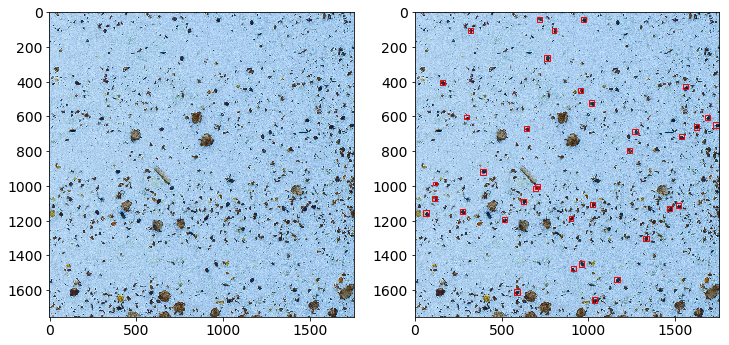

In [46]:
plot_img_plus_segmentation(ic, annotations_xmls)

In [47]:
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [169]:
img = rgb2gray(ic[0])
(winW, winH) = (50, 50)
generator = sliding_window(img, stepSize=50, windowSize=(winW, winH))

at position (200,50)


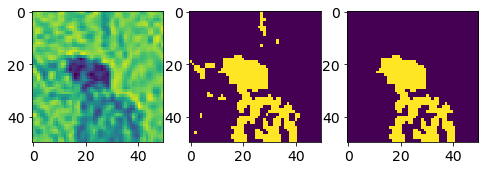

In [209]:
(x, y, image) = next(generator)
print("at position ({},{})".format(x, y))

bin_im = preprocess(image, True)

# ***

In [39]:
from skimage.measure import find_contours
from skimage.morphology import label
from skimage.measure import regionprops
## Definition of the sliding window generator
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

## Preprocessing of the window image to fit to varroa detection
def preprocess(img, show=False, threshold=0.65):
    EMPTY_IMAGE_THRESHOLD = threshold
    if(show):
        plt.subplot(1, 3, 1)
        plt.imshow(img)
    
    thresh = threshold_otsu(img)
    #print(thresh)
    if(thresh > EMPTY_IMAGE_THRESHOLD): 
        black_img = np.zeros_like(img)
        if(show):
            plt.subplot(1, 3, 2)
            plt.imshow(black_img)
            plt.show()
        return black_img
    else:
        binary = (img < thresh)
        
        if(show):
            plt.subplot(1, 3, 2)
            plt.imshow(binary)
        
    
        cleaned_binary = remove_small_objects(binary, 300).astype(int)
        bin_labels = label(cleaned_binary)
        props = regionprops(bin_labels)

        for prop in props:
            if((prop.filled_area - prop.area) > 1):
                cleaned_binary[prop.coords]=0
        if(show):
            plt.subplot(1, 3, 3)
            plt.imshow(cleaned_binary)
            plt.show()
            
        
        return cleaned_binary

# First descriptor with fourier
def get_fourier_descr(image):
    '''
     Get amplitude of the first four Fourier descriptor of an image 
        Inputs : The binary image to analyse
        Output : amplitude of the first four Fourier descriptor .
    '''

    contour = find_contours(image.astype(int), 0)
    contour_complex = np.empty(len(contour[0]), dtype=complex)
    contour_complex.real = contour[0][:, 0]
    contour_complex.imag = contour[0][:, 1]
    fourier_result = np.fft.fft(contour_complex)
    return fourier_result[:4]

# Hand chosen descriptors
def get_handy_descriptors(image, back_ground=0):
    '''
        Compute the descriptors for a binary_image:
        Input: binary_image
        Output: area, perimeter, compacity, elongation
    '''
    im_label = label(image, background=back_ground)
    properties_ = regionprops(im_label, coordinates='rc')
    descriptors = []
    for properties in properties_: 
        area = properties.area
        perimeter = properties.perimeter
        compacity = max(perimeter * perimeter / area, 4*np.pi)
        #elongation
        max_diameter = max(properties.minor_axis_length, properties.major_axis_length)
        min_diameter = min(properties.minor_axis_length, properties.major_axis_length)
        small_number = 1e-1
        elongation = max_diameter/min_diameter if(min_diameter != 0) else max_diameter/small_number
        descriptors.append([area, perimeter, compacity, elongation])
    return descriptors

In [48]:
import pandas as pd
from skimage.io import imsave
def detect_by_method_1(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''
    
    image_ = rgb2gray(img)
    image_ = image_/255
    d = {}
        
    # If we want area, perimeter, compacity, elongation descriptors
    d_handy = {'area': [], 'perimeter': [], 'compacity': [], 'elongation': [],
              'id': []}
    d.update(d_handy)   
    
    df = pd.DataFrame(d)
    
    # make a window of size winW x winH          
    (winW, winH) = (50, 50)
    stepsize = 50
    generator = sliding_window(image_, stepSize=stepsize, windowSize=(winW, winH))
    index = 0
    for (x, y, image) in generator:
        index += 1
        bin_im = preprocess(image)
        
        if (bin_im.min() != bin_im.max()):                
                descr = get_handy_descriptors(bin_im, back_ground=0)
                imsave('../project/img_deub/img'+str(index)+'.jpg', bin_im)
                for (area, perimeter, compacity, elongation) in descr:
                    d_handy = {'area': area, 'perimeter': perimeter, 'compacity': compacity, 
                               'elongation': elongation, 'id': index}
                    df = df.append(d_handy, ignore_index=True)
                
        else : 
            continue
    return df
    #Your code

In [49]:
df = detect_by_method_1(ic[0])

/Users/Raphael/anaconda3/envs/iapr2019/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ../project/img_deub/img15.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/Raphael/anaconda3/envs/iapr2019/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ../project/img_deub/img20.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/Raphael/anaconda3/envs/iapr2019/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ../project/img_deub/img32.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/Raphael/anaconda3/envs/iapr2019/lib/

/Users/Raphael/anaconda3/envs/iapr2019/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ../project/img_deub/img538.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/Raphael/anaconda3/envs/iapr2019/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ../project/img_deub/img559.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/Raphael/anaconda3/envs/iapr2019/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ../project/img_deub/img610.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/Raphael/anaconda3/envs/iapr2019/l

/Users/Raphael/anaconda3/envs/iapr2019/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ../project/img_deub/img837.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/Raphael/anaconda3/envs/iapr2019/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ../project/img_deub/img847.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/Raphael/anaconda3/envs/iapr2019/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ../project/img_deub/img852.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/Raphael/anaconda3/envs/iapr2019/l

Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/Raphael/anaconda3/envs/iapr2019/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ../project/img_deub/img1236.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [53]:
import seaborn as sns

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [4]:
#Your code

## Part 3: Using MLP and CNNs

Add your implementation for the thrid part. Feel free to add your desirable functions, but please make sure you have proper functions for the final detection, where their input and output follows the same format as the previous parts.

https://kapernikov.com/tutorial-image-classification-with-scikit-learn/

https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_censure.html

## Challenge

You can generate a json submission file by using the function ''**generate_pred_json**''. This prediction file can be uploaded online for evaluation (Please refer to section 3 of the project description for more details).

In [6]:
import numpy as np
import json

def generate_pred_json(data, tag='baseline'):
    '''
    Input
    - data: Is a dictionary d, such that:
          d = { 
              "ID_1": [], 
              "ID_2": [[x_21, y_21, w_21, h_21], [x_22, y_22, w_22, h_22]], 
              ... 
              "ID_i": [[x_i1, y_i1, w_i1, h_i1], ..., [x_iJ, y_iJ, w_iJ, h_iJ]],
              ... 
              "ID_N": [[x_N1, y_N1, w_N1, h_N1]],
          }
          where ID is the string id of the image (e.i. 5a05e86fa07d56baef59b1cb_32.00px_1) and the value the Kx4 
          array of intergers for the K predicted bounding boxes (e.g. [[170, 120, 15, 15]])
    - tag: (optional) string that will be added to the name of the json file.
    Output
      Create a json file, "prediction_[tag].json", conatining the prediction to EvalAI format.
    '''
    unvalid_key = []
    _data = data.copy()
    for key, value in _data.items():
        try:
            # Try to convert to numpy array and cast as closest int
            print(key)
            v = np.around(np.array(value)).astype(int)
            # Check is it is a 2d array with 4 columns (x,y,w,h)
            if v.ndim != 2 or v.shape[1] != 4:
                unvalid_key.append(key)
            # Id must be a string
            if not isinstance(key, str):
                unvalid_key.append(key)
            _data[key] = v.tolist()
        # Deal with not consistant array size and empty predictions
        except (ValueError, TypeError):
            unvalid_key.append(key)
    # Remove unvalid key from dictionnary
    for key in unvalid_key: del _data[key]
    
    with open('prediction_{}.json'.format(tag), 'w') as outfile:
        json.dump(_data, outfile)

In [7]:
#Your code